In [1]:
from ase.io import read
import matplotlib.pyplot as plt

import abtem

# Multislice simulations

The multislice algorithm works by propagating the 2D lateral part of the wave function slice-by-slice forward along the optical axis (which in abTEM is by definition the positive `z` direction). A forward step through a slice of the potential consists of a transmission and a propagation. The `Waves` can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete one forward step, the transmitted wave is then propagated by a distance corresponding to the thickness of the slice using the Fresnel free-space approximation.

We create a `Potential` and a `PlaneWave`:

In [2]:
atoms = read('data/srtio3_110.cif')

potential = abtem.Potential(atoms, slice_thickness=1)

wave = abtem.PlaneWave(energy=300e3, sampling=.05)

To propagate the wave function through the potential we use the `.multislice` method.

In [3]:
pw_exit_wave = wave.multislice(potential)

By default the multislice calculation is [lazy](), to run the simulation we call `compute`.

In [4]:
pw_exit_wave.compute();

We show the intensity of the resulting exit wave.

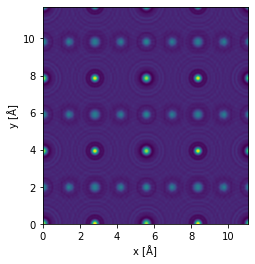

In [5]:
pw_exit_wave.show();

In [6]:
pw_exit_wave.to_zarr('data/srtio3_110_exit_wave.zarr', overwrite=True)

imported_wave = abtem.from_zarr('data/srtio3_110_exit_wave.zarr')

The electron diffraction pattern can be obtained using the `.diffraction_patterns` method. We set `block_direct=True` since the direct beam often has much higher intensity than the scattered beams and thus we can't show it on the same scale.

In [7]:
pw_diffraction_pattern = pw_exit_wave.diffraction_patterns(block_direct=True)

We show the diffraction pattern.

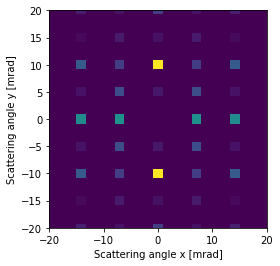

In [8]:
ax, im = pw_diffraction_pattern.show(angular_units=True)

ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20]);

It may be unexpected that the diffraction spot looks like squares, this is because the incoming beam is an infinite coherent plane wave, which means that the diffraction spots are single points. However, we are discretizing the wave function on a square grid (i.e. pixels), hence the spots can only be as small as single pixels.

<div class= "alert alert-info">

**Note:**

You may have noted that the grid of the wave function was not given above. Using the multislice function, the wave function adopts the grid of the potential before starting the multislice propagation. On the other hand, the following will result in an error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next lines will also result in an error because the sampling of the wave function and the potential is different.

```python
wave = PlaneWave(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```
    
</div>

## Multislice simulation with probe
For a probe, we additionally define the probe convergence semiangle (in mrad) via `semiangle_cutoff`. Imaging modes utilizing an electron probe requires us to provide a positions for the probe (here a single location at 5 Å both in $x$ and $y$).

In [11]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=20)

We can position the probe on an atom be reading the `xy` position of one of the Sr atoms.

In [12]:
position = atoms.positions[200][:2]

position

array([5.5225    , 7.81003905])

We then simulate the exit wave via a multislice simulation of the probe placed at this position.

In [13]:
probe_exit_wave = probe.multislice(scan=position, potential=potential).compute()

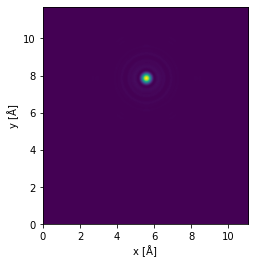

In [14]:
probe_exit_wave.show();

The convergent-beam electron diffraction (CBED) pattern can be calculated in the same manner as the ED pattern. We again display the result on a log scale. Note that to get more useful results, we should go back and increase our sampling of the potential.

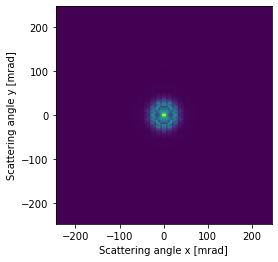

In [15]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_patterns()

ax, im = cbed_diffraction_pattern.show(angular_units=True)

## Normalization

By default abTEM wave functions are normalized so the Fourier space intensity integrates to 1, i.e. the sum of a diffraction pattern is 1. 

In [16]:
incoming_probe = probe.build(lazy=False)

incoming_probe.diffraction_patterns().array.sum()

1.0

We expect the wave function intensity to be conserved in a multislice simulation. In practice, this is not strictly true as intensity may be lost if the wave function scatters above the antialiasing angle of the simulation. In the simulation above we lost 0.05 % of the initial intensity and more intensity would be lost for thicker potentials.

In [17]:
probe_exit_wave.diffraction_patterns().array.sum()

0.9946275

We can improve this by increasing the number of grid points thus increasing the antialiasing angle and losing less intensity.

Of course the intensity is not necessarily conserved after applying an aperture or a detector to the wave function. In particular, annular dark field modes detects a tiny fraction of the incoming intensity. 

In [20]:
pw_exit_wave

In [22]:
integrated_intensity = abtem.AnnularDetector(inner=50, outer=120).detect(pw_exit_wave)

None


NameError: name 'sss' is not defined

## Thickness series

